## Data

In [55]:
import numpy as np
import pandas as pd
from one.api import ONE
from psyfun import io

In [56]:
# instantiating: basic connection
one = ONE()

In [47]:
# Load recordings from previous query 
## FIX ME

#df_recordings = io.load_recordings()

In [48]:
# Make a list with the datasets containing a left camera raw recording in project brainwide.
sesh = list(one.search(datasets = ['_iblrig_leftCamera.raw.mp4'],
project = "brainwide"))

# Select the experiment index 2.
eid = sesh[2]
print(eid)

5ae68c54-2897-4d3a-8120-426150704385


In [49]:
# List video-related datasets:
"""
From all the datasets associated with a certain experiment_id, return all the ones with a video (Camera) in them.
"""
[dataset for dataset in one.list_datasets(eid) if 'Camera' in dataset]

['alf/_ibl_leftCamera.dlc.pqt',
 'alf/_ibl_leftCamera.features.pqt',
 'alf/_ibl_leftCamera.lightningPose.pqt',
 'alf/_ibl_leftCamera.times.npy',
 'alf/_ibl_rightCamera.dlc.pqt',
 'alf/_ibl_rightCamera.features.pqt',
 'alf/_ibl_rightCamera.times.npy',
 'alf/leftCamera.ROIMotionEnergy.npy',
 'alf/rightCamera.ROIMotionEnergy.npy',
 'raw_video_data/_iblrig_leftCamera.raw.mp4',
 'raw_video_data/_iblrig_rightCamera.raw.mp4']

In [50]:
# returns the local path where files are stored based on exp_ID.
import os

url = one.eid2path(eid)
print(os.path.exists(url))

video_path = os.path.join(url, "raw_video_data", "_iblrig_leftCamera.raw.mp4")
print(video_path)


True
C:\Users\marti\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab_ucla\Subjects\MFD_08\2023-09-07\001\raw_video_data\_iblrig_leftCamera.raw.mp4


In [51]:
# Use io.video to stream video data instead of dodwnloading full videos
import ibllib.io.video as vidio
label = 'left' # 'left', 'right' or 'body'

# Find url of video data to stream
#url = vidio.url_from_eid(eid, one=one)[label]

# Load the first 10 video frames
frames = vidio.get_video_frames_preload(video_path, range(10))
print(frames.shape)

(10, 1024, 1280, 3)[2K


In [52]:
vidio.get_video_frames_preload?

Signature:
vidio.get_video_frames_preload(
    vid,
    frame_numbers=None,
    mask=Ellipsis,
    as_list=False,
    func=<function <lambda> at 0x000001C3AC0185E0>,
    quiet=False,
)
Docstring:
Obtain numpy array corresponding to a particular video frame in video.
Fetching and returning a list is about 33% faster but may be less memory controlled. NB: Any
gain in speed will be lost if subsequently converted to array.
:param vid: URL or local path to mp4 file or cv2.VideoCapture instance.
:param frame_numbers: video frames to be returned. If None, return all frames.
:param mask: a logical mask or slice to apply to frames
:param as_list: if true the frames are returned as a list, this is faster but may be less
memory efficient
:param func: Function to be applied to each frame. Applied after masking if applicable.
:param quiet: if true, suppress frame loading progress output.
:return: numpy array corresponding to frame of interest, or list if as_list is True.
Default dimensions are (n, 

In [53]:
# Get video metadata
meta = vidio.get_video_meta(video_path, one=one)
for k, v in meta.items():
    print(f'The video {k} = {v}')

The video length = 356039
The video fps = 60
The video width = 1280
The video height = 1024
The video duration = 1:38:53.983333
The video size = 12288883431


Odd alert. Color matrices are not equal, choose one of them for analysis (Davide will check)

## PCA analysis

create a motion-energy heat map.

1) compute narray with consecutive pixel differences (will miss one timestamp)
2) svd the array for pca analysis
3) pca on the covariance (check stringer paper for svd tip)

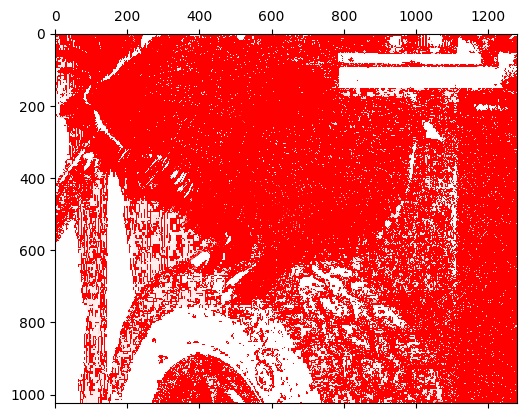

In [10]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# motion energy array
pixeldif = np.diff(frames[...,0], axis = 0)

heatmap_av = np.mean(pixeldif, axis =0)

fig, ax = plt.subplots()

ax.matshow(heatmap_av, norm = 'linear', cmap = 'bwr', vmin = -5, vmax = 5) # looking horrible

## functions

should i standardize or minmax normalize?

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import scipy.optimize
import seaborn as sns
from scipy.stats import entropy

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA


def get_frames(url, init, n_frames):
    """
    Gets n_frames frames from a video at url location.

    Parameters
    ----------
    url: string
        Local or digital location for the video. If locally saved, use one.eid2path(eid) to know location (eid i.e. experimental id)

    init, n_frames: integers
        Init refers to initial index. n_frames is the number of frames in the video segment.
        
    Returns
    -------
    numpy.ndarray
        An array of shape (n_frames, height, width) containing movie frames.
    
    """

    return vidio.get_video_frames_preload(url, range(init, init+n_frames), mask = np.s_[...,0])


def exponential (x, tau):
     """
    Exponential curve for fit.

    Parameters
    ----------
    x: float
        Function variable.

    tau: float
        Decay constant.

        
    Returns
    -------
    function: numpy.exp
        Exponential function with parameters as input.
    
    """
     return np.exp(-x/tau)


def motion_energy(frames):
    """
    Computes the motion energy matrix for each frame segment.
    
    Calculates pixel energy differences across frames.

    Parameters
    ----------
    frames: numpy.ndarray
        An array of shape (n_frames, height, width, channel) containing segmented frames from a given video.

    Returns
    -------
    numpy.ndarray
        An array of shape (n_frames - 1, height, width) containing the motion energy differences for each pixel
        in different timestamps
    
    """
    return np.diff(frames[...], axis = 0)

def run_pca(energymatrix, components, plot = False):
    """
    Runs Principal Component Analysis (PCA) for each video segment.

    Reshapes the energy matrix so that each row represents a frame (height x width pixels) and min-max normalizes the matrix.
    Computes Principal Components via Singular Value Decomposition based on number or explained variance threshold.
    Fits an exponential curve to the explained variance to inspect individual components' explained variance contribution. 
    
    Parameters
    ----------
    energymatrix : numpy.ndarray
        Array of shape (n_frames, height, width) containing motion energy differences in a video segment
    components:
        (int) Number of components to extract; (float) 0 < cmp < 1; explained variance threshold
    plot: boolean
        Enables plotting of explained variance curve.

    Returns
    -------
    pca: sklearn.PCA()
        a PCA object containing the results of the PCA analysis.
    
    dict
        A dictionary containing the first principle component's variance explained,
        the variance explained by all components, the tau (exponential decay rate of the 
        PCA spectrum), and the normalized spectral entropy.        
    """
    n_frames = energymatrix.shape[0]

    X = energymatrix.reshape(n_frames, -1)

    # setting up the pca: normalization and fit
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    pca = PCA(components)
    pca.fit(X_norm)

    # computing curves of variance decay
    [tau], _ = scipy.optimize.curve_fit(exponential, np.arange(pca.n_components_), pca.explained_variance_ratio_/pca.explained_variance_ratio_[0])

    dict_measures = {}
    dict_measures[f'pc1'] = pca.explained_variance_ratio_[0] # first component
    dict_measures[f'pcs'] = pca.explained_variance_ratio_ # all components
    dict_measures[f'tau'] = tau # decay constant
    dict_measures[f'ngsc'] = entropy(pca.explained_variance_ratio_) / np.log2(pca.n_components_) # Shannon's entropy; measure of information contained by the system
    # plotting for frame
    if plot == True:
        fig, ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_)
        ax.set_xlabel('Component number')
        ax.set_ylabel(f'Variance explained')
        ax.set_title(f'Variance explained per component for video segment')
    return pca, dict_measures

def run_ipca(energymatrix, components, plot = False):
    """
    Runs Incremental Principal Component Analysis (PCA) for each video segment.

    Reshapes the energy matrix so that each row represents a frame (height x width pixels) and min-max normalizes the matrix.
    Computes Principal Components via Singular Value Decomposition in batches to optimize comptutation.
    Fits an exponential curve to the explained variance to inspect individual components' explained variance contribution. 
    
    
    Parameters
    ----------
    energymatrix : numpy.ndarray
        Array of shape (n_frames, height, width) containing motion energy differences in a video segment
    
    components: integer
        Number of components to extract from the video. Default is 200 based on observation.
    plot: boolean
        Enables plotting of explained variance curve.

    Returns
    -------
    pca: sklearn.IPCA()
        a PCA object containing the results of the PCA analysis.
    
    dict
        A dictionary containing the first principle component's variance explained,
        the variance explained by all components, the tau (exponential decay rate of the 
        PCA spectrum), and the normalized spectral entropy.        
    """

    n_frames = energymatrix.shape[0]

    X = energymatrix.reshape(n_frames, -1)

    # setting up the pca: normalization and fit
    scaler = MinMaxScaler()
    X_norm = scaler.fit_transform(X)
    pca = IncrementalPCA(components)
    pca.fit(X_norm)

    # computing curves of variance decay
    [tau], _ = scipy.optimize.curve_fit(exponential, np.arange(pca.n_components_), pca.explained_variance_ratio_/pca.explained_variance_ratio_[0])

    dict_measures = {}
    dict_measures[f'pc1'] = pca.explained_variance_ratio_[0] # first component
    dict_measures[f'pcs'] = pca.explained_variance_ratio_ # all components
    dict_measures[f'tau'] = tau # decay constant
    dict_measures[f'ngsc'] = entropy(pca.explained_variance_ratio_) / np.log2(pca.n_components_) # Shannon's entropy; measure of information contained by the system
    # plotting for frame
    if plot == True:
        fig, ax = plt.subplots()
        ax.plot(pca.explained_variance_ratio_)
        ax.set_xlabel('Component number')
        ax.set_ylabel(f'Variance explained')
        ax.set_title(f'Variance explained per component for video segment')
    return pca, dict_measures

 # test functions
def get_80comp(pca: PCA):
    
    variance = np.cumsum(pca.explained_variance_)
    comp80 = np.searchsorted(variance, 0.8) + 1

    return pca.components_[:comp80]

1) Temporarily, get 3600 frames.
2) Run a PCA and save the components that explain 80% of the variance.
3) store only those components

Complexity problem: each 3600f segment is taking ~3min to process all components explaining 80% of var. There are 100 segments.

Memory problem: storing the components can be tricky - huge memory demand

Solution: 

Facemap solution involves downsampling the video by taking pixel averages.

1) Optimize by batches (Incremental PCA)
2) Parallel processing (no clue how to implement, ask chat)
3) cut the video (buuuh)
4) FaceMap

## movie pca

In [19]:
import gc 

frames_per_batch= 100  # 60 seconds * frames per second
total_frames = meta['length']
n_segments = total_frames // frames_per_batch

movie_components = []
for i in range(2):
    start = i * frames_per_batch
    frames_segment = get_frames(video_path, start, frames_per_batch)

    pixel_dif = motion_energy(frames_segment)
    del frames_segment
    gc.collect()

    pca_frames, _ = run_pca(pixel_dif, 0.8) # otherwise, run_pca(pixel_dif, 0.8)
    del pixel_dif
    gc.collect()
    
    movie_components.append(pca_frames.components_) # appends the components returned from iPCA that explain 80%var

# Stack all the segment components into one massive temporal matrix
movie_matrix = np.vstack(movie_components)

#print(f"Total segments: {n_segments}")

In [20]:
print(movie_matrix.shape)

movie_matrix

(139, 1310720)


array([[-1.08882421e-03, -1.17731201e-04, -1.80477655e-04, ...,
         1.07323647e-03,  1.00929540e-03,  2.85162222e-04],
       [-2.83721773e-04,  3.22880198e-05,  9.49917591e-04, ...,
         4.08836389e-04,  2.15024185e-04,  1.57043759e-03],
       [ 1.04866708e-03,  1.27374866e-05, -3.33355420e-05, ...,
        -1.21180153e-03,  5.54779833e-04, -1.08333424e-03],
       ...,
       [-2.76197607e-04, -2.57230524e-04, -5.16371640e-04, ...,
         1.67690783e-03,  2.94188046e-04,  5.82863423e-04],
       [-3.25514617e-04, -6.41300027e-04,  1.07241246e-04, ...,
        -4.14651211e-04,  5.68339339e-04, -2.54381987e-05],
       [-1.28141909e-03, -1.40050202e-04,  2.23666457e-04, ...,
         2.43757430e-03,  2.32192750e-03,  3.43664657e-04]],
      shape=(139, 1310720))

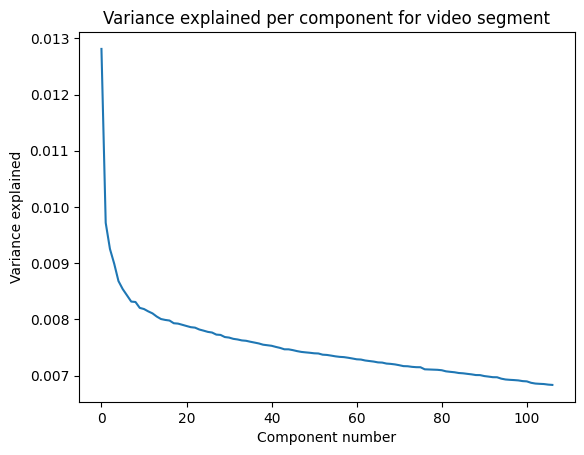

In [21]:
moviepca, moviedict = run_pca(movie_matrix, 0.8, True)

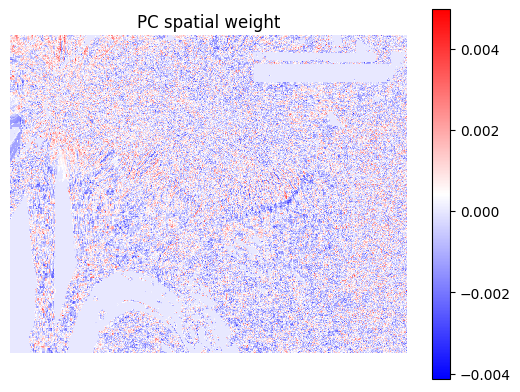

In [54]:
height, width = meta['height'], meta['width']

## first component

pc1 = moviepca.components_[8]

plt.figure()
plt.imshow(pc1.reshape((height, width)), cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('PC spatial weight')
plt.axis('off')
plt.show()

(5, 1310720)


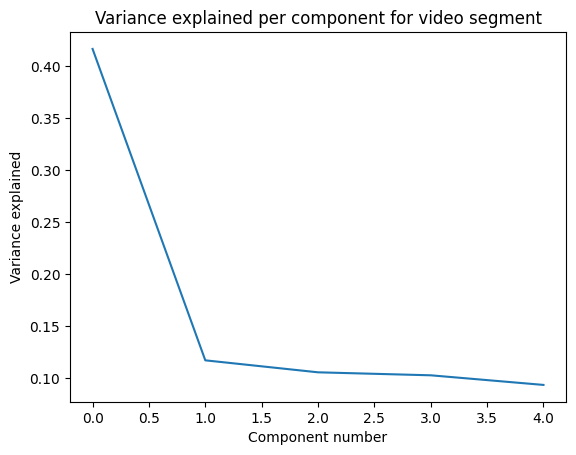

In [ ]:
pixel_dif = motion_energy(frames)
pca_frame, frame1 = run_pca(pixel_dif,True)

print(pca_frame.components_.shape)

In [44]:
height, width = pixel_dif.shape[1], pixel_dif.shape[2]

## first component

pc1 = pca_frame.components_[0]

plt.figure()
plt.imshow(pc1.reshape((height, width)), cmap='bwr', interpolation='nearest')
plt.colorbar()
plt.title('PC 1 spatial weight')
plt.axis('off')
plt.show()

NameError: name 'pixel_dif' is not defined

In [25]:
print(url)

C:\Users\marti\Downloads\ONE\openalyx.internationalbrainlab.org\churchlandlab_ucla\Subjects\MFD_08\2023-09-07\001


In [32]:
import pandas as pd
import pprint

pca_path = os.path.join(url, 'raw_video_data', '_iblrig_leftCamera.raw_proc.npy')

pca_results = np.load(pca_path, allow_pickle=True).item()

pprint.pprint(pca_results.keys())

dict_keys(['filenames', 'save_path', 'Ly', 'Lx', 'sbin', 'fullSVD', 'save_mat', 'Lybin', 'Lxbin', 'sybin', 'sxbin', 'LYbin', 'LXbin', 'avgframe', 'avgmotion', 'avgframe_reshape', 'avgmotion_reshape', 'motion', 'motSv', 'movSv', 'motMask', 'movMask', 'motMask_reshape', 'movMask_reshape', 'motSVD', 'movSVD', 'pupil', 'running', 'blink', 'rois', 'sy', 'sx'])


In [43]:
avgmotion = pca_results['avgmotion_reshape']

print(avgmotion[0].shape)

(142,)
